If using google drive please edit this line to connect to drive location

In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
from google.colab import drive
import os, sys

# Mount the google colab
drive.mount("/content/drive/")
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'DeepLearning_GroupProject/'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
!ls {GOOGLE_DRIVE_PATH}
sys.path.append(GOOGLE_DRIVE_PATH)

# GOOGLE_DRIVE_PATH = '.'


# relative paths
models_dir = 'models'
csv_path = 'Data/updated_data_with_lists.csv'
tensors_dir = 'Data/tensor_batch_notaugmented'

Mounted at /content/drive/
 best_models				  pictures_for_report.pptx
 best_models_em				 'Project Task List.gsheet'
 Code					  __pycache__
 Data					  recipe_encoder.py
 emily_recipe_checkpoint_12-09_10-17.db   runner_bk.py
 emily_recipe_checkpoint_12-09_10-19.db   runner.py
 emily_recipe_checkpoint_12-09_10-20.db   training_12_2_version.ipynb
 emily_recipe_checkpoint_12-09_10-27.db   training.ipynb
 emily_recipe_checkpoint_12-09_10-28.db   training_jaketesting.ipynb
 emily_recipe_checkpoint_12-09_10-30.db   training_optuna_emily.ipynb
'Image Recipe.gdoc'			  training_optuna.ipynb
 Main.ipynb				  training_with_tokens.ipynb
 models


In [ ]:
import pandas as pd
from ast import literal_eval
import numpy as np
import torch

# Explicitly adding models to the search path
models_path = os.path.join(GOOGLE_DRIVE_PATH, models_dir)
if models_path not in sys.path:
    sys.path.insert(0, models_path)

from models import recipe_encoder

csv_file = os.path.join(GOOGLE_DRIVE_PATH,csv_path)
df = pd.read_csv(csv_file, converters={"Cleaned_Ingredients": literal_eval, "Instructions": literal_eval})
print(len(df))
df.head()

13496


,Unnamed: 0,Title,Instructions,Image_Name,Cleaned_Ingredients
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"[Pat chicken dry with paper towels, season all...",miso-butter-roast-chicken-acorn-squash-panzanella,"[1 (3½–4-lb.) whole chicken, 2¾ tsp. kosher sa..."
1,1,Crispy Salt and Pepper Potatoes,[Preheat oven to 400°F and line a rimmed bakin...,crispy-salt-and-pepper-potatoes-dan-kluger,"[2 large egg whites, 1 pound new potatoes (abo..."
2,2,Thanksgiving Mac and Cheese,[Place a rack in middle of oven; preheat to 40...,thanksgiving-mac-and-cheese-erick-williams,"[1 cup evaporated milk, 1 cup whole milk, 1 ts..."
3,3,Italian Sausage and Bread Stuffing,[Preheat oven to 350°F with rack in middle. Ge...,italian-sausage-and-bread-stuffing-240559,"[1 (¾- to 1-pound) round Italian loaf, cut int..."
4,4,Newton's Law,[Stir together brown sugar and hot water in a ...,newtons-law-apple-bourbon-cocktail,"[1 teaspoon dark brown sugar, 1 teaspoon hot w..."


Concatenate the batches of preprocessed images into 1 tensor

In [ ]:
pt_files = os.listdir(os.path.join(GOOGLE_DRIVE_PATH,tensors_dir))
all_image_tensors = []
all_image_labels = []

# Load and combine all .pt files
for pt_file in pt_files[:2]:  #[:1]:
    pt_filepath = os.path.join(GOOGLE_DRIVE_PATH,tensors_dir,pt_file)
    image_tensors, image_labels = torch.load(pt_filepath)
    all_image_tensors.append(image_tensors)
    all_image_labels.extend(image_labels)
    print(f"Loaded {pt_file}")

# Concatenate tensors
all_image_tensors = torch.cat(all_image_tensors)
print(f"Number of images: {all_image_tensors.size(0)}")
print(f"Number of labels: {len(all_image_labels)}")
assert all_image_tensors.size(0) == len(all_image_labels), "Mismatch between images and labels!"

<ipython-input-5-d8da03f840fa>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_tensors, image_labels = torch.load(pt_filepath)


Loaded batch_0.pt
Loaded batch_1.pt
Number of images: 2000
Number of labels: 2000


Reorganize dataframe to be in the same order as the Image Tensors using the image_label as the matching key

In [ ]:
##Reset order of dataframe to match the image labels orders
all_image_labels_cleaned = [label.split(".")[0] for label in all_image_labels] #remove the .png and .jgp
print(all_image_labels_cleaned[:10]) #print to see if at the end the df matches

filtered_df = df[df["Image_Name"].isin(all_image_labels_cleaned)] #filter the df to only have values from the images
print(filtered_df["Image_Name"][:10])
print(df.shape)
print(filtered_df.shape, len(all_image_labels_cleaned))

valid_labels = set(filtered_df['Image_Name'])

# Filter labels and tensors
filtered_labels_and_tensors = [
    (tensor, label) for tensor, label in zip(all_image_tensors, all_image_labels_cleaned) if label in valid_labels
]

# Unpack the filtered data
filtered_tensors, filtered_labels = zip(*filtered_labels_and_tensors)

# Convert back to tensors
filtered_tensors = torch.stack(filtered_tensors)
filtered_labels = list(filtered_labels)

# Verify alignment
print(f"Number of filtered tensors: {len(filtered_tensors)}")
print(f"Number of filtered labels: {len(filtered_labels)}")
print(f"Number of rows in filtered_df: {len(filtered_df)}")

# Finally reorganize the df to be in the same order as the image tensors
filtered_df = filtered_df.set_index("Image_Name").loc[filtered_labels].reset_index()
print(filtered_df["Image_Name"][:10])

['spanish-style-grilled-vegetables-with-breadcrumb-picada-238806', 'three-cheese-pizza-with-onion-sage-and-arugula-233543', 'speedy-skillet-ravioli-lasagna', 'summer-anchovy-salad-51108430', 'spice-roasted-cornish-hens-with-cucumber-yogurt-sauce-353418', 'stovetop-butterscotch-apples-and-cranberries', 'tarte-tatin-51196820', 'spanish-olive-and-cream-cheese-canapes-231160', 'spice-rubbed-sustainable-fish-sliders', 'spiced-pumpkin-layer-cake-240123']
2            thanksgiving-mac-and-cheese-erick-williams
5                  warm-comfort-tequila-chamomile-toddy
7                     turmeric-hot-toddy-claire-sprouse
9        spiced-lentil-and-caramelized-onion-baked-eggs
11          spiral-ham-in-the-slow-cooker-guarnaschelli
24    sloppy-joe-shirred-eggs-with-spinach-vivian-ho...
27                           spicy-coconut-pumpkin-soup
30                                trinidad-curry-powder
32                          trinidadian-green-seasoning
47                              veselkas-fa

In [ ]:
filtered_df.head()

,Image_Name,Unnamed: 0,Title,Instructions,Cleaned_Ingredients
0,spanish-style-grilled-vegetables-with-breadcru...,10787,Spanish-Style Grilled Vegetables with Breadcru...,[Prepare barbecue (medium heat). Arrange veget...,[3 large red bell peppers (about 1 1/2 pounds)...
1,three-cheese-pizza-with-onion-sage-and-arugula...,12145,"Three-Cheese Pizza with Onion, Sage, and Arugula",[Place pizza stone on floor of gas oven or on ...,[1 (1/4-oz) package active dry yeast (2 1/4 te...
2,speedy-skillet-ravioli-lasagna,551,Speedy Skillet Ravioli Lasagna,[Preheat the oven to 450°F with a rack in the ...,"[2 tbsp. extra-virgin olive oil, 2 large garli..."
3,summer-anchovy-salad-51108430,6117,Summer Anchovy Salad,[Cut tomatoes into fat wedges. Drizzle with ol...,"[Tomatoes, Olive oil, Splash of vinegar, Crumb..."
4,spice-roasted-cornish-hens-with-cucumber-yogur...,8769,Spice-Roasted Cornish Hens with Cucumber-Yogur...,[Position rack in top third of oven; preheat t...,"[3 1 1/4 to 1 1/2-pound Cornish game hens, spl..."


Reformat Ingredients, Recipes, and Image titles

Tokenize Recipes, Ingredients, and Image Titles

In [ ]:

from transformers import AutoTokenizer
total_max = 128
# Initialize the tokenizer
tokenizer_recipes = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_nested_list(nested_list, max_length=128):
    """
    Tokenizes a nested list of strings (list of ingredients per recipe).
    Each inner list is tokenized into a list of token IDs.
    """
    tokenized_list = []
    for sublist in nested_list:
        # Join the inner list into a string
        # text = " ".join(sublist)
        text = str(sublist)
        # Tokenize the string
        tokens = tokenizer_recipes(
            text,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        # Append tokenized input_ids to the result list
        tokenized_list.append(tokens["input_ids"].squeeze(0).tolist())
    return tokenized_list

filtered_df['Title_List'] = df['Title'].apply(lambda x: [x])
filtered_df['tokenized_ingredients'] = filtered_df['Cleaned_Ingredients'].apply(lambda x: tokenize_nested_list(x, total_max))
filtered_df['tokenized_instructions'] = filtered_df['Instructions'].apply(lambda x: tokenize_nested_list(x, total_max))
filtered_df['tokenized_titles'] = filtered_df['Title_List'].apply(lambda x: tokenize_nested_list(x, total_max))


# # Store tokenized data in a dictionary for your DataLoader
# filtered_df["tokenized_titles"] = title_tokens["input_ids"]
# filtered_df["title_attention_mask"] = title_tokens["attention_mask"]

# filtered_df["tokenized_ingredients"] = ingredients_tokens["input_ids"]
# filtered_df["ingredients_attention_mask"] = ingredients_tokens["attention_mask"]

# filtered_df["tokenized_instructions"] = instructions_tokens["input_ids"]
# filtered_df["instructions_attention_mask"] = instructions_tokens["attention_mask"]
print(len(filtered_df["tokenized_titles"][0]))
print(filtered_df["tokenized_ingredients"][0])
print(filtered_df["tokenized_instructions"][0])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

1
[[101, 1017, 2312, 2417, 4330, 23582, 1006, 2055, 1015, 1015, 1013, 1016, 7038, 1007, 1010, 27674, 1010, 13916, 1010, 4284, 2098, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1018, 2312, 2887, 8288, 24759, 11390, 1006, 2055, 1015, 1015, 1013, 1018, 7038, 1007, 1010, 21920, 1010, 3013, 3091, 14244, 2046, 1017, 25609, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1018, 5396, 2665, 2030, 3756, 16950, 25955, 3490, 1006, 9544, 8231, 1016, 

In [ ]:
def pad_or_truncate_nested(sublist, target_length, max_length, pad_token=0):
        """
            Pad or truncate the outer list of a nested list to match the target_length.
            Each inner list remains untouched.
        """
        # Pad with [pad_token] or truncate the outer list
        if len(sublist) < target_length:
            sublist.extend([[pad_token]* max_length] * (target_length - len(sublist)))
        else:
            sublist = sublist[:target_length]
        return sublist

max_length_ing = filtered_df['tokenized_ingredients'].apply(len).max()
max_length_inst = filtered_df['tokenized_instructions'].apply(len).max()//4
max_length_title = filtered_df['tokenized_titles'].apply(len).max()
filtered_df['tokenized_ingredients'] = filtered_df['tokenized_ingredients'].apply(
    lambda ing: pad_or_truncate_nested(ing, max_length_ing,total_max))

filtered_df['tokenized_instructions'] = filtered_df['tokenized_instructions'].apply(
    lambda inst: pad_or_truncate_nested(inst, max_length_inst, total_max))
# new_token_ing = [pad_or_truncate_nested(ing, max_length_title) for ing in tokenized_ingredients] #titles were all list length of 1
max_length_ing = filtered_df['tokenized_ingredients'].apply(len).max()
max_length_inst = filtered_df['tokenized_instructions'].apply(len).max()
max_length_title = filtered_df['tokenized_titles'].apply(len).max()
print(max_length_ing, max_length_inst, max_length_title)
print(len(filtered_df['tokenized_ingredients'][5]))
print(filtered_df['tokenized_ingredients'][100])

42 23 1
42
[[101, 1015, 1013, 1018, 2452, 9724, 3514, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1016, 3009, 24444, 1010, 20956, 1998, 4857, 2135, 15920, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1016, 2312, 18856, 21818, 2015, 20548, 1010, 20956, 1998, 24881, 1010, 4606, 1018, 18856, 21818, 2015, 2878, 20548, 1010, 20956, 102, 0, 0, 0, 0, 0, 0, 0,

Tokenize the Image Labels for the Image Encoder

In [ ]:
from transformers import AutoTokenizer
from transformers import CLIPModel
model_name = "openai/clip-vit-base-patch16"
clip_model = CLIPModel.from_pretrained(model_name)
tokenizer_images = AutoTokenizer.from_pretrained(model_name)

tokenized_labels = tokenizer_images(
    filtered_labels,
    padding="max_length",
    truncation=True,
    max_length=tokenizer_images.model_max_length,
    return_tensors="pt"
)

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
%reload_ext autoreload


cuda:0

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn
class RecipeDecoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(RecipeDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim

    def forward(self, input_tokens):
        embedded = self.embedding(input_tokens)
        outputs, hidden_state = self.rnn(embedded, hidden_state)
        predictions = self.fc_out(outputs)
        return predictions

In [ ]:
def calc_recall(top, image_features, recipe_embeddings, image_labels):
  true_pos = 0
  false_neg = 0
  tmp_batches = image_features.shape[0]
  print(image_features.shape, recipe_embeddings.shape)
  for i in range(tmp_batches):
    cosine_similarity = torch.nn.CosineSimilarity(dim=1)
    similarities = cosine_similarity(image_features[i, :].unsqueeze(0), recipe_embeddings)
    print(similarities)
    #top = amount of top results to retrieve
    top_results = top
    top_k_values, top_k_indices = torch.topk(similarities, top_results, largest=True)
    print(top_k_values, top_k_indices)
    top_images = [(filtered_df['Image_Name'][i]) for i in top_k_indices]
    if image_labels[i] in [image[0] for image in top_images]:
      true_pos += 1
    else:
      false_neg += 1

  return (true_pos / tmp_batches)


In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from models.image_2_recipe import Image2Recipe
from models.image_encoder import Image_Encoder
from models.recipe_encoder import RecipeEncoder
from models.MMR import MMR
from models.MMR import MMR_losses
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

class Data_Loading(Dataset):
    """
    Class to combine the Images, Labels, Recipes together to be used in combination when inputted into Model
    """
    def __init__(self, tokenized_ingredients, tokenized_instructions, tokenized_titles, image_tensors, image_labels):
        self.ingredients = torch.tensor(tokenized_ingredients, dtype=torch.int16)
        self.instructions = torch.tensor(tokenized_instructions, dtype=torch.int16)
        self.titles = torch.tensor(tokenized_titles, dtype=torch.int16)
        self.images = image_tensors
        self.image_labels = image_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {
            "ingredients": self.ingredients[idx],
            "instructions": self.instructions[idx],
            "titles": self.titles[idx],
            "images": self.images[idx],
            "image_labels": self.image_labels[idx]
            # "tokenized_labels": {
            #     "input_ids": self.tokenized_labels['input_ids'][idx].to(dtype=torch.long),
            #     "attention_mask": self.tokenized_labels['attention_mask'][idx].to(dtype=torch.uint8)
            # }
        }



class Trainer(object):
    """
    Class designed to run ViT (train, evaluate, plot)
    """

    def __init__(self, **kwargs):
        """
        Initialize ViT
        """
        self.epochs = kwargs['epochs']
        self.optimizer_name = kwargs['optimizer']
        self.device = kwargs['device']
        self.batch_size = kwargs['batch_size']
        self.lr = kwargs['learning_rate']

        self.tokenized_ingredients = kwargs['ingredient_tokens']
        self.tokenized_instructions = kwargs['instruction_tokens']
        self.tokenized_title = kwargs['title_tokens']
        self.image_tensor = kwargs['image_tensors']
        self.image_labels = kwargs['image_labels']
        self.clip_model = kwargs['clip_model']
        self.vocab_size = kwargs['vocab_size']
        self.max_len = kwargs['max_len']
        self.instance_weight = kwargs['instance_weight']
        self.sem_weight = kwargs['sem_weight']
        self.itm_weight = kwargs['itm_weight']
        self.best_model_parameters = kwargs['best_model_parameters_path']
        self.initial_margin = kwargs['initial_margin']
        self.margin_step = kwargs['margin_step']
        self.max_margin = kwargs['max_margin']
        self.topk = kwargs['topk']
        self.fixed_margin = kwargs['fixed_margin']
        self.improvement_threshold = kwargs['improvement_threshold']
        self.patience = kwargs['patience']

        self.mmr_heads = kwargs['mmr_heads']
        self.ITEM_lyrs = kwargs['ITEM_lyrs']
        self.MTD_lyrs = kwargs['MTD_lyrs']
        self.recipe_enc_hidden = kwargs['recipe_enc_hidden']
        # self.patience = 5
        MMR_type = "type_separate" #""
        # Pending variable margin calc
        # self.loss_calcs = MMR_losses(margin=1.0, instance_weight=self.instance_weight, sem_weight=self.sem_weight, itm_weight=self.itm_weight)
        self.loss_calcs = MMR_losses(instance_weight=self.instance_weight, sem_weight=self.sem_weight, itm_weight=self.itm_weight)
        # num_classes = len(set(self.image_labels['input_ids']))
        num_classes = len(set(self.image_labels))
        # print(num_classes)


        # self.image_encoder = Image_Encoder(self.device, self.clip_model, num_classes).to(self.device)
        # self.recipe_encoder = RecipeEncoder(self.device, self.vocab_size, self.max_len, hidden_dim=self.recipe_enc_hidden).to(self.device)
        # self.mmr = MMR(hidden_dim=self.image_encoder.clip_model.config.projection_dim, num_heads=self.mmr_heads, ITEM_lyrs=self.ITEM_lyrs, MTD_lyrs=self.MTD_lyrs, MMR_type=MMR_type).to(self.device)

        self.image_encoder = Image_Encoder(self.device, self.clip_model, num_classes).to(self.device)
        self.recipe_encoder = RecipeEncoder(self.device, self.vocab_size, self.max_len).to(self.device)
        self.mmr = MMR(hidden_dim=self.image_encoder.clip_model.config.projection_dim).to(self.device)
        # self.recipe_decoder = RecipeDecoder(512,512,self.vocab_size).to(self.device)
        # MMR varaibles: num_heads=num_heads, ITEM_lyrs=ITEM_lyrs, MTD_lyrs=MTD_lyrs, projection_dim=projection_dim,  MMR_type="type_separate")
        self.model = Image2Recipe(self.image_encoder, self.recipe_encoder, self.mmr).to(self.device)


        ##DO we want to tune each of these learning rates for each model?
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        # self.optimizer2 = torch.optim.Adam(self.recipe_decoder.parameters(), lr=self.lr)
        # self.optimizer = torch.optim.AdamW([
        #     {"params": self.model.image_encoder.parent_model.parameters(), "lr": 1e-6},
        #     {"params": self.model.recipe_encoder.parameters(), "lr": 1e-5},
        #     {"params": self.model.image_encoder.fc1.parameters(), "lr": 1e-5},
        #     {"params": self.model.recipe_encoder.ll_e.parameters(), "lr": 1e-5},
        # ])


        #Combine Images, Recipes, Instructions in training and eval datasets
        self.data_total = Data_Loading(
            self.tokenized_ingredients,
            self.tokenized_instructions,
            self.tokenized_title,
            self.image_tensor,
            self.image_labels
        )
        training_perc = 0.7
        train_size = int(training_perc * len(self.data_total))
        eval_size = len(self.data_total) - train_size
        train_dataset, eval_dataset = random_split(self.data_total, [train_size, eval_size])
        self.dataloader = {}
        self.dataloader['train'] = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)
        self.dataloader['eval'] = DataLoader(eval_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)

        #Lists to fill up during training and plotted later for learning curves
        self.train_loss_list = []
        self.train_loss_actual_list = []
        self.eval_loss_list = []
        self.eval_acc_list = []
        self.eval_acc_list = []
        self.best_score = 0
        self.best_loss = 1000
        print("finished initializing")

        # self.CELoss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
        # self.decoder_lambda = kwargs['decoder_lambda']

    def train(self):
        """
        Train ViT, image encoder, recipe encoder, MMR
        """
        # Set initial margin
        self.margin = self.initial_margin
        patience_count = 0
        early_stop = False

        for epoch in range(self.epochs):
            if early_stop == True:
                break

            for phase in ['eval', 'train']:
                if early_stop == True:
                    break
                total_loss = 0
                total_loss_actual = 0
                total_accuracy = 0
                total_eval_loss = 0
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()
                j = 0  # limit print statements
                for i, batch_data in enumerate(tqdm(self.dataloader[phase],position=0, leave=True)):
                    #Looping through batches of training data then eval data each epoch
                    #TODO: Add how the recipe, instructions, and titles will be tokenized
                    ingredients, instructions, titles, images, image_labels = (
                        batch_data['ingredients'].to(self.device),
                        batch_data['instructions'].to(self.device),
                        batch_data['titles'].to(self.device),
                        batch_data['images'].to(self.device),
                        batch_data['image_labels']
                    )

                    recipe_enc_src = [titles, ingredients, instructions]
                    self.optimizer.zero_grad()

                    if phase == 'train':
                        output = self.model(images, image_labels, recipe_enc_src)
                        ##Combine the Recipe Encoder Losses and Image Encoder Losses based on TFOOD
                        mmr_logits = output["mmr_logits"]
                        image_logits = output["image_logits"]
                        image_embeddings_proj = output["image_embeddings_proj"]
                        recipe_embeddings_proj = output["recipe_embeddings_proj"]
                        # image_embeddings = output["image_embeddings"]
                        # recipe_embeddings = output["recipe_embeddings"]

                        # #Train the Recipe Decoder so it can output a generative (Title, Ingredient, Instructions)
                        # title_logits = self.recipe_decoder(image_embeddings, titles)
                        # ingredients_logits = self.recipe_decoder(image_embeddings, ingredients)
                        # instructions_logits = self.recipe_decoder(image_embeddings, instructions)

                        # #Compute Reconstruction Loss
                        # title_loss = self.CELoss(title_logits.transpose(1, 2), titles)
                        # ingredients_loss = self.CELoss(ingredients_logits.transpose(1, 2), ingredients)
                        # instructions_loss = self.CELoss(instructions_logits.transpose(1, 2), instructions)
                        # decoder_loss = (title_loss + ingredients_loss + instructions_loss) *self.decoder_lambda
                        # Get a value for the fixed loss to get a nice loss curve
                        comparison_loss = self.loss_calcs.total_loss(image_logits, image_embeddings_proj,
                                                          recipe_embeddings_proj, mmr_logits, margin=self.fixed_margin)
                        loss = self.loss_calcs.total_loss(image_logits, image_embeddings_proj,
                                                          recipe_embeddings_proj, mmr_logits, margin=self.margin)


                        if j%10 == 0:
                          print(f'training loss for step: {loss.item()}')
                        j += 1
                        # recall_score = calc_recall(self.topk, image_embeddings_proj, recipe_embeddings_proj, image_labels)
                        # print(recall_score)

                        total_loss += comparison_loss.item()
                        total_loss_actual += loss.item()

                        loss.backward()
                        self.optimizer.step()
                        # self.optimizer2.step() #decoder optimizer

                    else: ##Eval mode
                        with torch.no_grad():
                            output = self.model(images, image_labels, recipe_enc_src)
                            mmr_logits = output["mmr_logits"]
                            image_logits = output["image_logits"]
                            image_embeddings_proj = output["image_embeddings_proj"]
                            recipe_embeddings_proj = output["recipe_embeddings_proj"]
                            # #Train the Recipe Decoder so it can output a generative (Title, Ingredient, Instructions)
                            # title_logits = self.recipe_decoder(image_embeddings, titles)
                            # ingredients_logits = self.recipe_decoder(image_embeddings, ingredients)
                            # instructions_logits = self.recipe_decoder(image_embeddings, instructions)

                            # #Compute Reconstruction Loss
                            # title_loss = self.CELoss(title_logits.transpose(1, 2), titles)
                            # ingredients_loss = self.CELoss(ingredients_logits.transpose(1, 2), ingredients)
                            # instructions_loss = self.CELoss(instructions_logits.transpose(1, 2), instructions)
                            # decoder_loss = (title_loss + ingredients_loss + instructions_loss) * self.decoder_lambda
                            # eval loss has a fixed margin because we want the best model
                            eval_loss = self.loss_calcs.total_eval_loss(image_logits, image_embeddings_proj,
                                                                   recipe_embeddings_proj, margin=self.fixed_margin)  # + decoder_loss

                            total_eval_loss += eval_loss.item()

                            if j%10 == 0:
                              sem_loss = self.loss_calcs.instance_semantic_loss(image_embeddings_proj, recipe_embeddings_proj, image_logits, margin=self.fixed_margin, mode='semantic')
                              inst_loss = self.loss_calcs.instance_semantic_loss(image_embeddings_proj, recipe_embeddings_proj, image_logits, margin=self.fixed_margin, mode='instance')
                              print(f'sem_loss for eval step: {sem_loss.item()}')
                              print(f'inst_loss for eval step: {inst_loss.item()}')
                            j += 1
                            # self.eval_loss_list.append(loss.item())

                            # recall_score = calc_recall(self.topk, image_embeddings_proj, recipe_embeddings_proj, image_labels)
                            # print(recall_score)


                    # del unused_tensor
                    torch.cuda.empty_cache() #clear cache after each batch
                    # print(i)
                    # print(output)



                # print(f"{phase}: Epoch {epoch+1}, Loss: {total_loss / len(self.dataloader[phase])}")

                # Update loss margin
                if self.margin <= (self.max_margin - self.margin_step):
                    self.margin += self.margin_step
                else:
                    self.margin = self.max_margin
                if phase == "train":
                  print(f"Epoch {epoch+1}, Loss: {total_loss / len(self.dataloader[phase])}")
                  self.train_loss_list.append(total_loss/len(self.dataloader[phase]))
                  self.train_loss_actual_list.append(total_loss_actual/len(self.dataloader[phase]))
                else:
                  print(f"Epoch {epoch+1}, Eval loss: {total_eval_loss / len(self.dataloader[phase])}")
                  total_eval_loss = total_eval_loss / len(self.dataloader[phase])
                  self.eval_loss_list.append(total_eval_loss)

                  if (self.best_loss - total_eval_loss) > self.improvement_threshold:
                    print(f"{total_eval_loss} is < {self.best_loss}, saving best model")
                    patience_count = 0
                    self.best_loss = total_eval_loss
                    torch.save(self.model.state_dict(), self.best_model_parameters)
                  else:
                    patience_count += 1
                    print(f"{total_eval_loss} is not < {self.best_loss}, patience is at {patience_count} of {self.patience}")
                    if patience_count >= self.patience:
                      print("Early stopping")
                      early_stop = True
                      self.stop_epoch = epoch

    def save_training_results(self):
        data = {
            'Parameter': list(self.params.keys()),
            'Value': list(self.params.values()),
            'Best Loss': self.best_loss,
            'Training loss': self.train_loss_list[-1],
            'Epochs': self.stop_epoch
        }
        df = pd.DataFrame(data)

        save_path = '/content/drive/My Drive/training_results.csv'

        df_new_results.to_csv(save_path, mode='a', header=False, index=False)
        print(f"Training results saved to {save_path}")

    ##Waiting on training code to finish
    def plot_learning_loss_curves(self):
        """
        Plot accuracy and loss curves for training and eval accuracy/loss lists (item/epoch)
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_loss_list[1:], label='Training Loss')
        plt.plot(self.eval_loss_list[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.show()

        # plt.figure(figsize=(10, 5))
        # plt.plot(self.train_acc_list, label='Training Accuracy')
        # plt.plot(self.eval_acc_list, label='Validation Accuracy')
        # plt.xlabel('Epoch')
        # plt.ylabel('Accuracy')
        # plt.title('Accuracy Curve')
        # plt.legend()
        # plt.show()



In [ ]:
print(len(filtered_df['tokenized_ingredients'][1][0]))
print(len(filtered_df['tokenized_instructions'][1][0]))
print(len(filtered_df['tokenized_titles'][1][0]))
# Use Gradient Accumulation: If reducing the batch size is not desirable, you can simulate a larger batch size by accumulating gradients over multiple smaller batches. This allows you to train with a smaller effective batch size without sacrificing performance.

128
128
128


In [ ]:
# torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


2.5.1+cu121
True
finished initializing


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 54.86868667602539
inst_loss for eval step: 15.745266914367676
sem_loss for eval step: 60.77827072143555
inst_loss for eval step: 15.748785018920898
sem_loss for eval step: 64.73284912109375
inst_loss for eval step: 15.978193283081055
Epoch 1, Eval loss: 41.38612392030913
41.38612392030913 is < 1000, saving best model


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 4.571661472320557
training loss for step: 9335.330078125
training loss for step: 4646.70068359375
training loss for step: 157.8031463623047
training loss for step: 98.3890609741211
training loss for step: 395.97491455078125
training loss for step: 339.39404296875
Epoch 1, Loss: 5611.066514001376


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 33.374778747558594
inst_loss for eval step: 14.233003616333008
sem_loss for eval step: 43.05665969848633
inst_loss for eval step: 15.103318214416504
sem_loss for eval step: 33.37477111816406
inst_loss for eval step: 14.729057312011719
Epoch 2, Eval loss: 28.366026648159686
28.366026648159686 is < 41.38612392030913, saving best model


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 163.34022521972656
training loss for step: 84.12532806396484
training loss for step: 13.626791954040527
training loss for step: 8.562233924865723
training loss for step: 10.75601863861084
training loss for step: 6.698180675506592
training loss for step: 7.278534889221191
Epoch 2, Loss: 45.10417012200839


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 30.95429229736328
inst_loss for eval step: 14.605253219604492
sem_loss for eval step: 26.113357543945312
inst_loss for eval step: 14.479541778564453
sem_loss for eval step: 30.954307556152344
inst_loss for eval step: 14.702983856201172
Epoch 3, Eval loss: 25.72044852684284
25.72044852684284 is < 28.366026648159686, saving best model


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 3.1079277992248535
training loss for step: 5.949456214904785
training loss for step: 2.5112252235412598
training loss for step: 2.4028193950653076
training loss for step: 2.4540011882781982
training loss for step: 2.4261345863342285
training loss for step: 2.4693024158477783
Epoch 3, Loss: 26.525123471799105


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 26.113357543945312
inst_loss for eval step: 14.92337703704834
sem_loss for eval step: 30.954299926757812
inst_loss for eval step: 14.933212280273438
sem_loss for eval step: 11.590522766113281
inst_loss for eval step: 14.087982177734375
Epoch 4, Eval loss: 27.177366717108363
27.177366717108363 is not < 25.72044852684284, patience is at 1 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 2.5062415599823
training loss for step: 4.3109965324401855
training loss for step: 6.1776018142700195
training loss for step: 2.4710183143615723
training loss for step: 2.4183788299560547
training loss for step: 2.4438705444335938
training loss for step: 2.5052878856658936
Epoch 4, Loss: 26.48384050009907


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 21.272415161132812
inst_loss for eval step: 14.738572120666504
sem_loss for eval step: 38.21571350097656
inst_loss for eval step: 15.45626163482666
sem_loss for eval step: 33.37477493286133
inst_loss for eval step: 15.191326141357422
Epoch 5, Eval loss: 28.318260751921557
28.318260751921557 is not < 25.72044852684284, patience is at 2 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 7.32663106918335
training loss for step: 14.837406158447266
training loss for step: 2.426954507827759
training loss for step: 7.697145462036133
training loss for step: 7.3023362159729
training loss for step: 12.9763765335083
training loss for step: 7.313844203948975
Epoch 5, Loss: 26.64187619306039


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 33.3747673034668
inst_loss for eval step: 15.307649612426758
sem_loss for eval step: 26.113357543945312
inst_loss for eval step: 15.13364028930664
sem_loss for eval step: 38.215721130371094
inst_loss for eval step: 15.37829875946045
Epoch 6, Eval loss: 29.58014415872508
29.58014415872508 is not < 25.72044852684284, patience is at 3 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 6.6253132820129395
training loss for step: 8.408041954040527
training loss for step: 10.361966133117676
training loss for step: 5.318315505981445
training loss for step: 3.4632115364074707
training loss for step: 12.931312561035156
training loss for step: 7.2748918533325195
Epoch 6, Loss: 25.57160454902096


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 26.113357543945312
inst_loss for eval step: 14.644472122192383
sem_loss for eval step: 28.533828735351562
inst_loss for eval step: 14.515851974487305
sem_loss for eval step: 43.056671142578125
inst_loss for eval step: 15.114896774291992
Epoch 7, Eval loss: 28.80635090531974
28.80635090531974 is not < 25.72044852684284, patience is at 4 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 16.329980850219727
training loss for step: 12.533368110656738
training loss for step: 5.016201972961426
training loss for step: 6.9872517585754395
training loss for step: 7.792581081390381
training loss for step: 15.3183012008667
training loss for step: 9.652166366577148
Epoch 7, Loss: 26.932486865831457


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 26.113357543945312
inst_loss for eval step: 14.554966926574707
sem_loss for eval step: 21.272411346435547
inst_loss for eval step: 14.350214004516602
sem_loss for eval step: 23.692882537841797
inst_loss for eval step: 14.29353141784668
Epoch 8, Eval loss: 28.386367074374494
28.386367074374494 is not < 25.72044852684284, patience is at 5 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 10.867423057556152
training loss for step: 14.61268424987793
training loss for step: 10.8563814163208
training loss for step: 18.36712074279785
training loss for step: 14.634148597717285
training loss for step: 6.568424224853516
training loss for step: 6.572327136993408
Epoch 8, Loss: 26.33676302260247


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 23.692886352539062
inst_loss for eval step: 14.379951477050781
sem_loss for eval step: 26.113357543945312
inst_loss for eval step: 14.615769386291504
sem_loss for eval step: 33.37477111816406
inst_loss for eval step: 14.557400703430176
Epoch 9, Eval loss: 27.54782150531637
27.54782150531637 is not < 25.72044852684284, patience is at 6 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 19.559818267822266
training loss for step: 15.825529098510742
training loss for step: 17.702465057373047
training loss for step: 19.54860496520996
training loss for step: 4.512862682342529
training loss for step: 12.079618453979492
training loss for step: 12.048995971679688
Epoch 9, Loss: 25.97722759799681


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 35.795249938964844
inst_loss for eval step: 14.996143341064453
sem_loss for eval step: 18.851943969726562
inst_loss for eval step: 14.168075561523438
sem_loss for eval step: 35.79524230957031
inst_loss for eval step: 14.892583847045898
Epoch 10, Eval loss: 28.04634403360301
28.04634403360301 is not < 25.72044852684284, patience is at 7 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 28.272987365722656
training loss for step: 18.885211944580078
training loss for step: 13.383231163024902
training loss for step: 18.883264541625977
training loss for step: 20.739782333374023
training loss for step: 20.775442123413086
training loss for step: 15.127442359924316
Epoch 10, Loss: 25.85893677974093


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 38.215721130371094
inst_loss for eval step: 15.343263626098633
sem_loss for eval step: 33.37477111816406
inst_loss for eval step: 15.242311477661133
sem_loss for eval step: 38.215721130371094
inst_loss for eval step: 15.61117935180664
Epoch 11, Eval loss: 28.222384683017072
28.222384683017072 is not < 25.72044852684284, patience is at 8 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 21.99184799194336
training loss for step: 20.110483169555664
training loss for step: 12.615730285644531
training loss for step: 14.973437309265137
training loss for step: 20.131433486938477
training loss for step: 18.2657413482666
training loss for step: 23.887792587280273
Epoch 11, Loss: 25.458963020988133


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 14.010967254638672
inst_loss for eval step: 14.325774192810059
sem_loss for eval step: 28.53380584716797
inst_loss for eval step: 15.022855758666992
sem_loss for eval step: 33.374778747558594
inst_loss for eval step: 15.100090026855469
Epoch 12, Eval loss: 29.014788660509833
29.014788660509833 is not < 25.72044852684284, patience is at 9 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 26.980619430541992
training loss for step: 25.048187255859375
training loss for step: 23.124670028686523
training loss for step: 21.24652862548828
training loss for step: 36.35588836669922
training loss for step: 30.703001022338867
training loss for step: 23.173139572143555
Epoch 12, Loss: 26.203908063363336


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 28.533828735351562
inst_loss for eval step: 14.803474426269531
sem_loss for eval step: 28.533828735351562
inst_loss for eval step: 14.879568099975586
sem_loss for eval step: 35.79524230957031
inst_loss for eval step: 15.209819793701172
Epoch 13, Eval loss: 28.16353837374983
28.16353837374983 is not < 25.72044852684284, patience is at 10 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 28.169471740722656
training loss for step: 26.30040168762207
training loss for step: 28.141075134277344
training loss for step: 22.543920516967773
training loss for step: 28.185317993164062
training loss for step: 26.267839431762695
training loss for step: 20.64215660095215
Epoch 13, Loss: 26.180088706638504


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 35.79524230957031
inst_loss for eval step: 15.148314476013184
sem_loss for eval step: 30.954299926757812
inst_loss for eval step: 15.08364486694336
sem_loss for eval step: 35.795249938964844
inst_loss for eval step: 15.306854248046875
Epoch 14, Eval loss: 28.58898794239965
28.58898794239965 is not < 25.72044852684284, patience is at 11 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 27.49679183959961
training loss for step: 25.59538459777832
training loss for step: 14.306034088134766
training loss for step: 33.11860275268555
training loss for step: 29.367115020751953
training loss for step: 21.841943740844727
training loss for step: 25.60369110107422
Epoch 14, Loss: 26.416960495105688


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 35.79524230957031
inst_loss for eval step: 15.247598648071289
sem_loss for eval step: 26.113357543945312
inst_loss for eval step: 15.184611320495605
sem_loss for eval step: 40.636192321777344
inst_loss for eval step: 15.76980209350586
Epoch 15, Eval loss: 28.73086561005691
28.73086561005691 is not < 25.72044852684284, patience is at 12 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 23.044673919677734
training loss for step: 38.03496551513672
training loss for step: 34.29197311401367
training loss for step: 32.48014831542969
training loss for step: 26.76345443725586
training loss for step: 38.09530258178711
training loss for step: 19.266006469726562
Epoch 15, Loss: 26.39978639630304


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 28.533828735351562
inst_loss for eval step: 15.022422790527344
sem_loss for eval step: 18.851940155029297
inst_loss for eval step: 14.549967765808105
sem_loss for eval step: 30.954307556152344
inst_loss for eval step: 15.161684036254883
Epoch 16, Eval loss: 28.10355068075246
28.10355068075246 is not < 25.72044852684284, patience is at 13 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 33.6390495300293
training loss for step: 37.432708740234375
training loss for step: 35.51961898803711
training loss for step: 28.004854202270508
training loss for step: 33.6128044128418
training loss for step: 39.27799606323242
training loss for step: 31.74943733215332
Epoch 16, Loss: 25.609815749569215


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 28.533832550048828
inst_loss for eval step: 14.927932739257812
sem_loss for eval step: 33.3747673034668
inst_loss for eval step: 15.226351737976074
sem_loss for eval step: 30.954303741455078
inst_loss for eval step: 15.281002044677734
Epoch 17, Eval loss: 28.529749705873687
28.529749705873687 is not < 25.72044852684284, patience is at 14 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 34.896522521972656
training loss for step: 38.58606719970703
training loss for step: 29.229881286621094
training loss for step: 32.930946350097656
training loss for step: 46.119110107421875
training loss for step: 34.871917724609375
training loss for step: 36.73194885253906
Epoch 17, Loss: 24.934618825497836


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 26.113357543945312
inst_loss for eval step: 15.175191879272461
sem_loss for eval step: 28.533832550048828
inst_loss for eval step: 15.150620460510254
sem_loss for eval step: 38.215721130371094
inst_loss for eval step: 15.527239799499512
Epoch 18, Eval loss: 28.042087752243567
28.042087752243567 is not < 25.72044852684284, patience is at 15 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 49.192012786865234
training loss for step: 36.043025970458984
training loss for step: 43.533321380615234
training loss for step: 41.71052551269531
training loss for step: 39.81856155395508
training loss for step: 41.7257080078125
training loss for step: 37.93555450439453
Epoch 18, Loss: 25.589005760524582


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 23.69287872314453
inst_loss for eval step: 15.006399154663086
sem_loss for eval step: 35.79522705078125
inst_loss for eval step: 15.390176773071289
sem_loss for eval step: 23.692886352539062
inst_loss for eval step: 15.026534080505371
Epoch 19, Eval loss: 27.97047200696222
27.97047200696222 is not < 25.72044852684284, patience is at 16 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 44.77726745605469
training loss for step: 50.39144515991211
training loss for step: 46.600685119628906
training loss for step: 40.99641036987305
training loss for step: 40.97597885131836
training loss for step: 41.00330352783203
training loss for step: 46.61978530883789
Epoch 19, Loss: 26.77344629038935


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 35.79522705078125
inst_loss for eval step: 15.215056419372559
sem_loss for eval step: 30.954299926757812
inst_loss for eval step: 15.032169342041016
sem_loss for eval step: 28.53382110595703
inst_loss for eval step: 15.126903533935547
Epoch 20, Eval loss: 28.945022451466528
28.945022451466528 is not < 25.72044852684284, patience is at 17 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 44.069252014160156
training loss for step: 38.48271560668945
training loss for step: 44.05949401855469
training loss for step: 45.94838333129883
training loss for step: 51.58164978027344
training loss for step: 49.70566177368164
training loss for step: 44.049041748046875
Epoch 20, Loss: 26.025734003039375


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 30.954296112060547
inst_loss for eval step: 15.30562973022461
sem_loss for eval step: 21.272415161132812
inst_loss for eval step: 14.654844284057617
sem_loss for eval step: 43.05665588378906
inst_loss for eval step: 15.769143104553223
Epoch 21, Eval loss: 28.668999178656215
28.668999178656215 is not < 25.72044852684284, patience is at 18 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 54.647640228271484
training loss for step: 52.77046203613281
training loss for step: 49.03935241699219
training loss for step: 62.1865119934082
training loss for step: 50.91790771484375
training loss for step: 47.16425704956055
training loss for step: 47.16304397583008
Epoch 21, Loss: 27.08130677541097


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 26.113338470458984
inst_loss for eval step: 14.866907119750977
sem_loss for eval step: 18.851943969726562
inst_loss for eval step: 14.445573806762695
sem_loss for eval step: 30.954303741455078
inst_loss for eval step: 15.25342082977295
Epoch 22, Eval loss: 26.907673145162647
26.907673145162647 is not < 25.72044852684284, patience is at 19 of 20


  0%|          | 0/69 [00:00<?, ?it/s]

training loss for step: 52.09339141845703
training loss for step: 48.33441162109375
training loss for step: 55.8515739440918
training loss for step: 52.099788665771484
training loss for step: 50.21922302246094
training loss for step: 46.484352111816406
training loss for step: 50.24544906616211
Epoch 22, Loss: 25.478160153264586


  0%|          | 0/29 [00:00<?, ?it/s]

sem_loss for eval step: 28.533828735351562
inst_loss for eval step: 15.07261848449707
sem_loss for eval step: 23.692882537841797
inst_loss for eval step: 14.989299774169922
sem_loss for eval step: 33.3747673034668
inst_loss for eval step: 15.081452369689941
Epoch 23, Eval loss: 26.435305233659417
26.435305233659417 is not < 25.72044852684284, patience is at 20 of 20
Early stopping


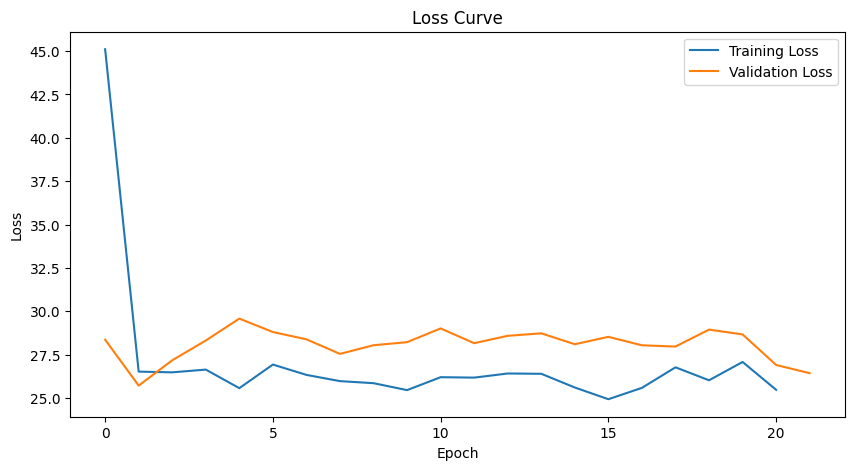

AttributeError: 'Trainer' object has no attribute 'params'

In [ ]:
# Cuda issues
print(torch.__version__)
print(torch.cuda.is_available())
vocab_size = tokenizer_recipes.vocab_size
param_path = os.path.join(GOOGLE_DRIVE_PATH, "models/best_model_jake.pth")
recipe_embeddings_path  = os.path.join(GOOGLE_DRIVE_PATH, "models/recipe_embeddings.pth")

kwargs = {
    'epochs': 200,
    'ingredient_tokens': filtered_df['tokenized_ingredients'].to_list(),
    'instruction_tokens': filtered_df['tokenized_instructions'].to_list(),
    'title_tokens': filtered_df['tokenized_titles'].to_list(),
    'image_tensors': filtered_tensors,
    'image_labels': filtered_df['Image_Name'],
    'device': device,
    'vocab_size': vocab_size,
    'max_len': total_max,
    'clip_model': clip_model,
    'optimizer': 'adam',
    'learning_rate': 1e-1,
    'batch_size': 20,
    'instance_weight': 1,
    'sem_weight': 5,
    'itm_weight': 0.5,
    'initial_margin': 5.0,
    'margin_step': 1,
    'max_margin': 1000.0,
    'best_model_parameters_path': param_path,
    'decoder_lambda': 0.1,
    'topk': 10,
    'patience': 20,
    'improvement_threshold': 0.001,
    'fixed_margin': 30,
    'mmr_heads': 4,
    'ITEM_lyrs': 1,
    'MTD_lyrs': 1,
    'recipe_enc_hidden':512

    # 'max_lengths': {
    #     'ingredient_tokens': max_length_ing,
    #     'instruction_tokens': max_length_inst,
    #     'title_tokens': max_length_title
    # }

}
image2recipe = Trainer(**kwargs)
image2recipe.train()
image2recipe.plot_learning_loss_curves()
image2recipe.save_training_results()

In [ ]:
image2recipe.plot_learning_loss_curves()
image2recipe.save_training_results('anything')

Now that the model is trained, use it to guess images recipes!

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  #same size as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #same norm as training
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0) #add batch dim of 1 at 0 indice

def extract_image_features(image, model, device):
  model.eval()
  with torch.no_grad():
      image_features = model.image_encoder(image.to(device))
      image_features = torch.nn.functional.normalize(image_features, p=2, dim=-1)
  return image_features

def load_model(model_path):
    image_encoder = Image_Encoder(device, clip_model, num_classes).to(device)
    recipe_encoder = RecipeEncoder(device, vocab_size, max_len).to(device)
    mmr = MMR(hidden_dim=image_encoder.clip_model.config.projection_dim).to(device)
    model = Image2Recipe(image_encoder, recipe_encoder, mmr).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

image_path = "insert test image path"
tensor_image = preprocess_image(image_path)
image2recipe = load_model(param_path)
image_features = extract_image_features(tensor_image, image2recipe.model, device)
print(image_features.shape)

recipe_embeddings = np.load(recipe_embeddings_path)


#Compute cosine similarities



In [ ]:
recipe_embeddings_path = os.path.join(GOOGLE_DRIVE_PATH, "models/recipe_embeddings.pth")

##load up the model
def load_model(model_path):
    num_classes = len(set(filtered_df['Image_Name']))
    max_len = total_max
    image_encoder = Image_Encoder(device, clip_model, num_classes).to(device)
    recipe_encoder = RecipeEncoder(device, vocab_size, max_len).to(device)
    mmr = MMR(hidden_dim=image_encoder.clip_model.config.projection_dim).to(device)
    model = Image2Recipe(image_encoder, recipe_encoder, mmr).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

model = load_model(param_path)

data_total = Data_Loading(
            filtered_df['tokenized_ingredients'].to_list(),
            filtered_df['tokenized_instructions'].to_list(),
            filtered_df['tokenized_titles'].to_list(),
            filtered_tensors,
            filtered_df['Image_Name']
        )

dataloader = DataLoader(data_total, batch_size=10, shuffle=False, drop_last=True)
##Create the recipe embedded space
all_recipe_embeddings = []
for i, batch in enumerate(dataloader):
  with torch.no_grad():
    ingredients, instructions, titles, images, image_labels = (
        batch['ingredients'].to(device),
        batch['instructions'].to(device),
        batch['titles'].to(device),
        batch['images'].to(device),
        batch['image_labels']
    )
    recipe_enc_src = [titles, ingredients, instructions]
    output = model(images, image_labels, recipe_enc_src)
    recipe_embeddings_proj = output["recipe_embeddings_proj"]
    all_recipe_embeddings.append(recipe_embeddings_proj)
    print(f"Batch: {i}/{len(dataloader)}")

recipe_embeddings_total = torch.cat(all_recipe_embeddings, dim=0)
print(recipe_embeddings_total.shape)
torch.save(recipe_embeddings_total, recipe_embeddings_path)


In [ ]:
recipe_embeddings_path = os.path.join(GOOGLE_DRIVE_PATH, "models/recipe_embeddings.pth")
recipe_embeddings = torch.load(recipe_embeddings_path)
param_path = os.path.join(GOOGLE_DRIVE_PATH, "models/best_model.pth")
vocab_size = tokenizer_recipes.vocab_size

##load up the model
def load_model(model_path):
    num_classes = len(set(filtered_df['Image_Name']))
    max_len = total_max
    image_encoder = Image_Encoder(device, clip_model, num_classes).to(device)
    recipe_encoder = RecipeEncoder(device, vocab_size, max_len).to(device)
    mmr = MMR(hidden_dim=image_encoder.clip_model.config.projection_dim).to(device)
    model = Image2Recipe(image_encoder, recipe_encoder, mmr).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

model = load_model(param_path)

data_total = Data_Loading(
            filtered_df['tokenized_ingredients'].to_list(),
            filtered_df['tokenized_instructions'].to_list(),
            filtered_df['tokenized_titles'].to_list(),
            filtered_tensors,
            filtered_df['Image_Name']
        )

dataloader = DataLoader(data_total, batch_size=10, shuffle=False, drop_last=True)
##Create the recipe embedded space
all_recipe_embeddings = []
for i, batch in enumerate(dataloader):
  with torch.no_grad():
    ingredients, instructions, titles, images, image_labels = (
        batch['ingredients'].to(device),
        batch['instructions'].to(device),
        batch['titles'].to(device),
        batch['images'].to(device),
        batch['image_labels']
    )
    recipe_enc_src = [titles, ingredients, instructions]
    output = model(images, image_labels, recipe_enc_src)
    image_embeddings_proj = output["image_embeddings_proj"]
    recall_score = calc_recall(10, image_embeddings_proj, recipe_embeddings, filtered_df['Image_Name'].to_list())
    print(recall_score)
    print(f"Batch: {i}/{len(d)}")

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
recipe_embeddings_path = os.path.join(GOOGLE_DRIVE_PATH, "models/recipe_embeddings.pth")
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #same size as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #same norm as training
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0) #add batch dim of 1 at 0 indice

def extract_image_features(image, model, device):
  model.eval()
  with torch.no_grad():
      image_logits, image_features = model.image_encoder(image.to(device), image_labels)
  return image_features

def load_model(model_path):
    num_classes = len(set(filtered_df['Image_Name']))
    max_len = total_max
    image_encoder = Image_Encoder(device, clip_model, num_classes).to(device)
    recipe_encoder = RecipeEncoder(device, vocab_size, max_len).to(device)
    mmr = MMR(hidden_dim=image_encoder.clip_model.config.projection_dim).to(device)
    model = Image2Recipe(image_encoder, recipe_encoder, mmr).to(device)
    model.load_state_dict(torch.load(model_path))
    return model

image_path = os.path.join(GOOGLE_DRIVE_PATH, "Data/test_images/pizza.png")
tensor_image = preprocess_image(image_path)
image2recipe = load_model(param_path)
image_features = extract_image_features(tensor_image, model, device)
print(image_features.shape)

recipe_embeddings = torch.load(recipe_embeddings_path)

recall_score = calc_recall(10, image_features, recipe_embeddings, filtered_df['Image_Name'].to_list())
print(recall_score)

#Compute cosine similarities